# Dat 402 Project 1 - Predicting Student Outcomes
# AJ Colapinto and Justin Raney

# Project Goal
The goal of this project is to develop two machine learning models that predict academic outcomes for students based on academic performance, financial status, and other background factors. The model outputs one of three categories:

- `0` = Dropout  
- `1` = Enrolled  
- `2` = Graduate

In a real world scenario, these predictions can be used to identify students at risk of dropping out and provide early interventions.

## Dataset

We use the *Predict Students' Dropout and Academic Success* dataset from the UCI Machine Learning Repository (Realinho et al., 2021). This dataset contains detailed records from students at a Portuguese higher education institution, including grades, enrollment data, and financial indicators.

- **Source**: [UCI Machine Learning Repository](https://doi.org/10.24432/C5MC89)  
- **Observations**: 4424 students  
- **Features**: 35+ variables including admission grades, scholarship status, tuition payments, and semester performance metrics

## Dataset Citation

Realinho, V., Vieira Martins, M., Machado, J., & Baptista, L. (2021). *Predict Students' Dropout and Academic Success* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5MC89

In [1]:
#import libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import MaxNLocator

# Data Preprocessing

Before training any models, we cleaned and prepared the dataset to make it suitable for machine learning.

## Key Steps:

- **Removed rows with missing values** in the `Target` column
- **Dropped irrelevant features** (e.g., `Marital_status`, `Course`, and other non-predictive fields)
- **Converted the target column (`Target`)** from strings to numeric codes:
  - `Dropout` → 0  
  - `Enrolled` → 1  
  - `Graduate` → 2
- **One-hot encoded categorical variables** to allow them to be used in machine learning models
- **Saved the cleaned dataset** to `cleaned_data.csv` for use in downstream scripts

In [260]:
file_path = "data.csv"
df = pd.read_csv(file_path, sep=";")

# Show the dataset info
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification     

One of the reasons we chose this dataset is that every value besides the target were already numeric, minimizing the need for data cleaning.

## Preview the data

In [264]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2          

The only downside of having categories already being numeric is that it requires looking up the code to see what specific values mean, such as "Mother's qualification" but this wasn't an issue for our overall project.

## Check for NaN or missing values

In [268]:
print("\nNumber of missing Values:")
print(df.isnull().sum())


Number of missing Values:
Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance\t                      0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                   

In [270]:
# Check target values (0 1 2)
print(df["Target"].unique())

# Convert target column to integer
df["Target"] = df["Target"].map({"Dropout": 0, "Enrolled": 1, "Graduate": 2})

# Check changes
print(df["Target"].value_counts())
print(df["Target"].unique())

# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)

['Dropout' 'Graduate' 'Enrolled']
Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0 2 1]


# Exploratory Data Analysis

C:\Users\ajcol\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
C:\Users\ajcol\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


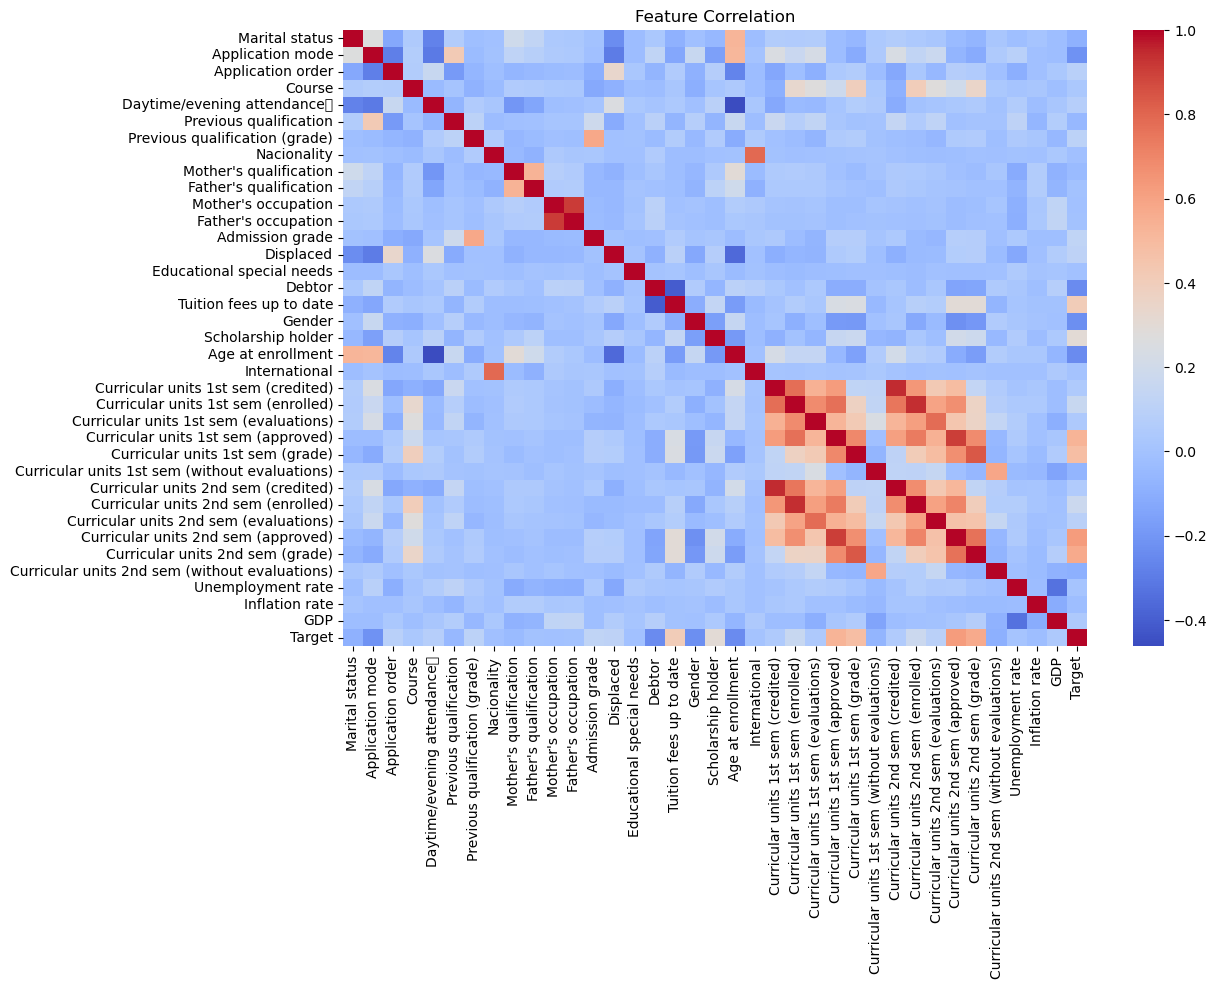

In [273]:
# Import previously cleaned data
df = pd.read_csv("cleaned_data.csv")

# Feature Selection (we will use correlation and histograms of each feature to determine the most relevant features)
# Basic correlation matrix
correlation_mat = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_mat, annot=False, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

There's clear clusters around the numbers of units per semester. The likely case is that taking less units means a student has more responsiblities outside of school, leading to more situations for them to fail classes in order to priortize other aspects of their life.

C:\Users\ajcol\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
C:\Users\ajcol\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


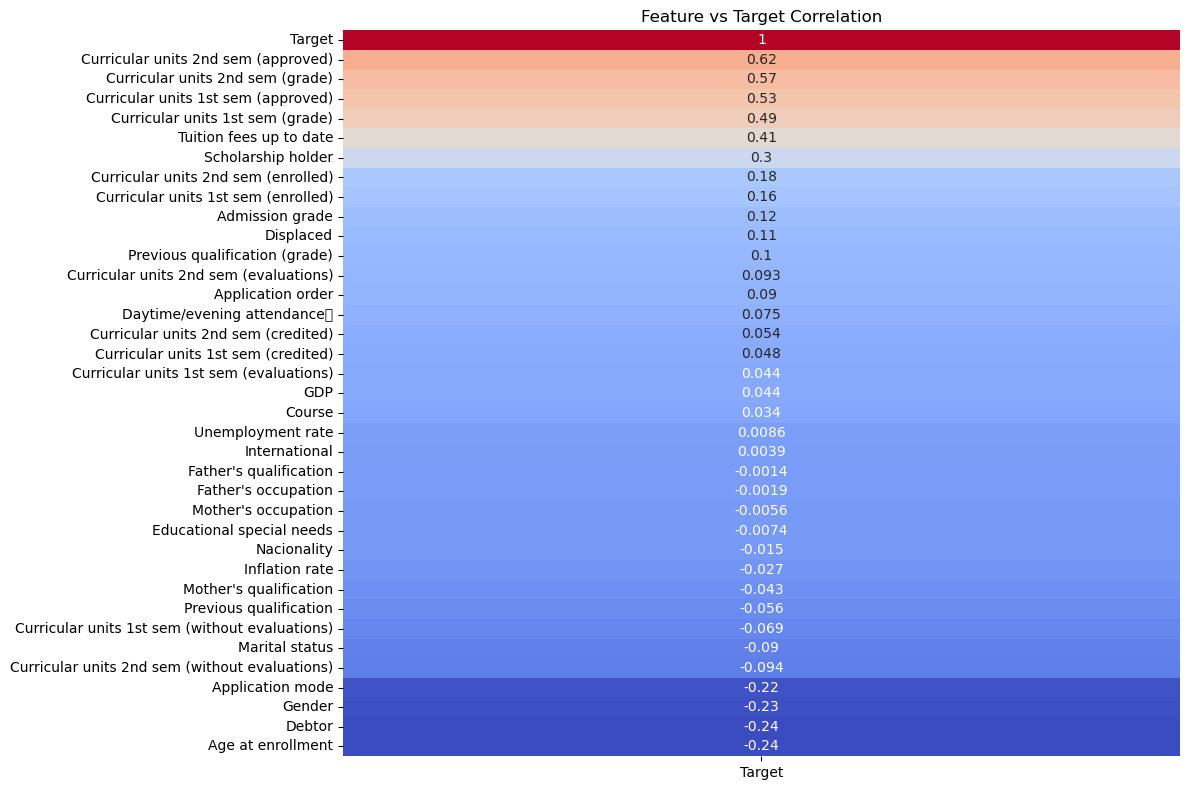

In [276]:
# Correlation with Target
correlation_with_target = df.corr()["Target"].sort_values(ascending=False)

plt.figure(figsize=(12,8))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Feature vs Target Correlation")
plt.tight_layout()
plt.show()

Tuition fees being up to date is a great example of how the student's financial situation matters more than the parents, as the parents' occupations are in the negatives.
Course being in the middle is interesting, as it seems that students likely do a good job of choosing classes they think they could pass.
Age at enrollment being the lowest could be assumed, as being older likely means more responsbilities to get in the way of school.

## FEATURE SELECTION
Based on overall correlation matrix, some features may be redundant. 
We chose to keep them all and will drop features based on model performance. 
All features selected have at least >=.3 correlation
Features - [Curr. units 1st and 2nd sem(approved), 1st and 2nd sem (grade), 1st and 2nd sem (approved) ,Tuition up to date, Target]

In [280]:
selected_features = ["Target", "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)", "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Tuition fees up to date", "Scholarship holder"]

df_selected_features = df[selected_features].copy()

# Rename features for ease of use

df_selected_features.rename(columns={
    "Curricular units 2nd sem (approved)": "2nd_sem_approved",
    "Curricular units 2nd sem (grade)": "2nd_sem_grade",
    "Curricular units 1st sem (approved)": "1st_sem_approved",
    "Curricular units 1st sem (grade)": "1st_sem_grade",
    "Tuition fees up to date": "tuition_utd",
    "Scholarship holder": "scholarship"}, inplace=True)

print("Columns:", df_selected_features.columns.tolist())

df_selected_features.to_csv("reduced_data.csv", index=False)

Columns: ['Target', '2nd_sem_approved', '2nd_sem_grade', '1st_sem_approved', '1st_sem_grade', 'tuition_utd', 'scholarship']


## Histograms of top "relevant" features

These histograms provide a better look at how our features react with respect to our targets.    
Curricular units approved and grade for both semesters show clusters, low values for target 0, and higher values for target 2, while target 1 is somewhere in between.
Tuition fees at first glance seems like it wouldn't be very predictive until you factor in the proportion of not up to date vs the targets.
Scholarship is nearly the opposite of tuition fees, however there is a more clear distinction between the proportion of targets and the binary of scholarship holders, this could indicate that scholarship holders are more likely to end up at target 2 than those without scholarships.

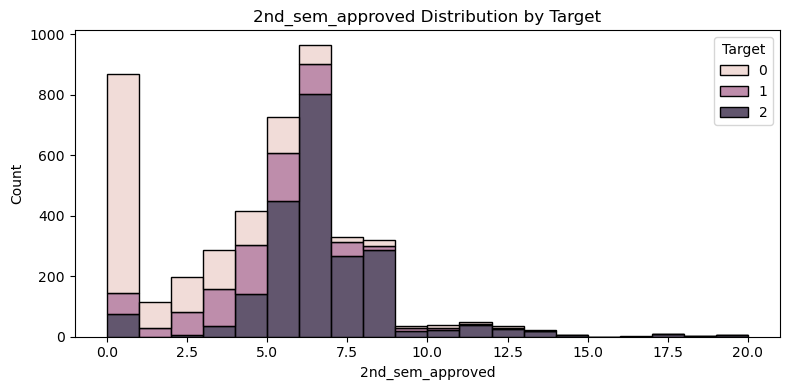

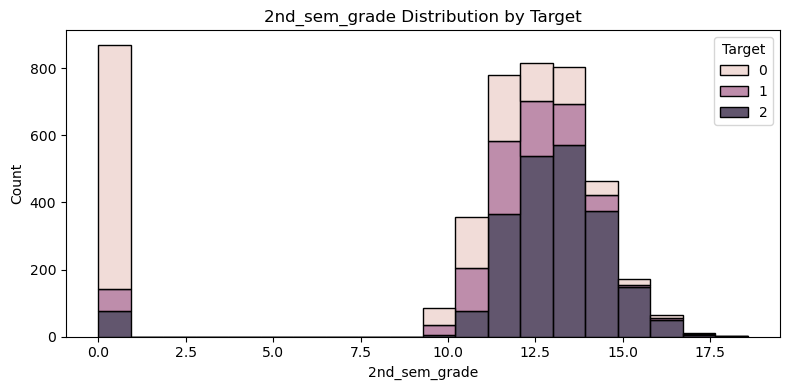

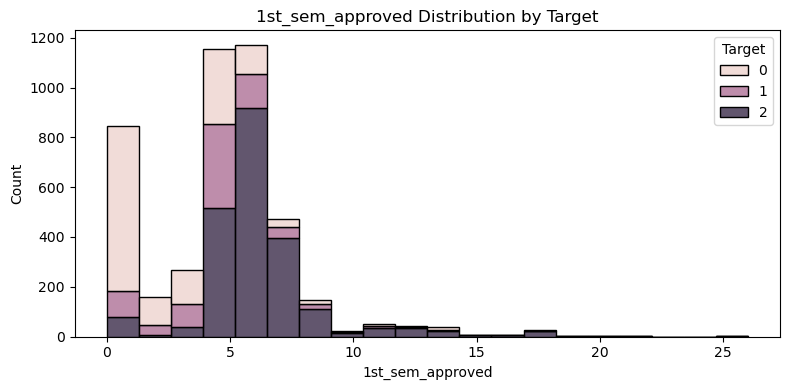

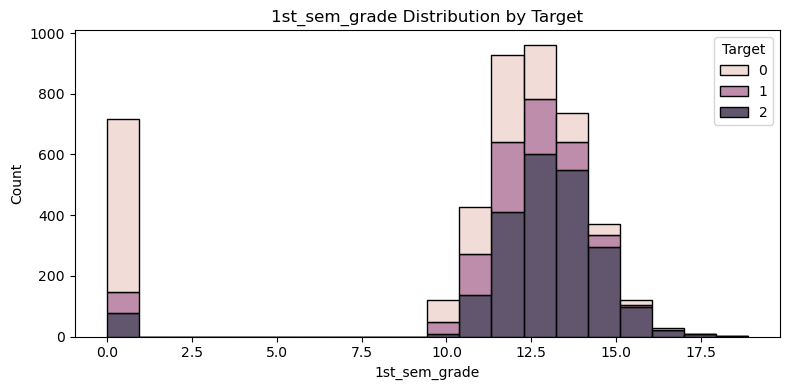

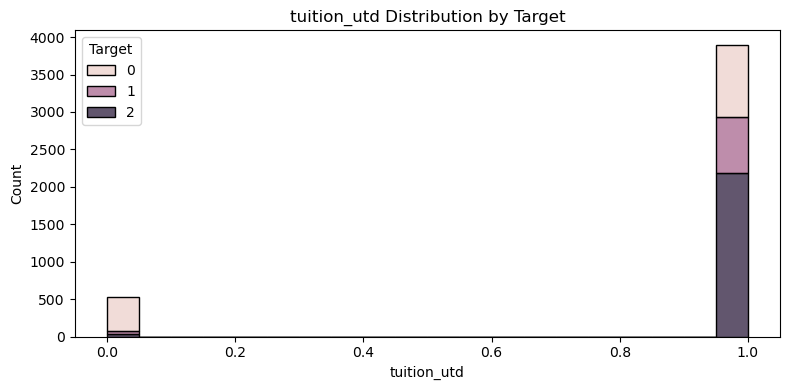

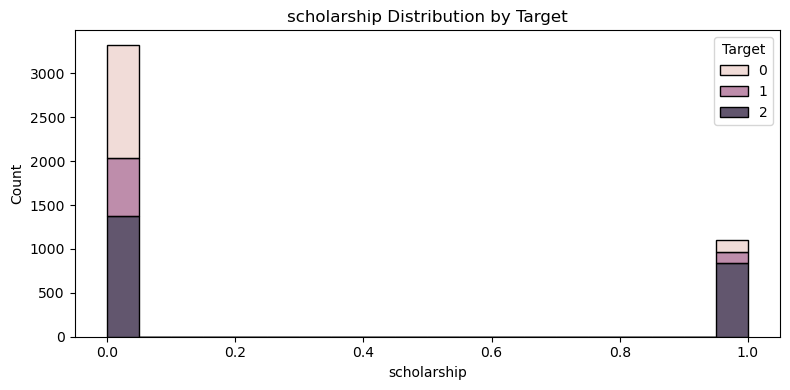

In [283]:
features = ["2nd_sem_approved", "2nd_sem_grade", "1st_sem_approved", "1st_sem_grade", "tuition_utd", "scholarship"]

for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df_selected_features, x=feature, hue="Target", multiple="stack", bins = 20)
    plt.title(f"{feature} Distribution by Target")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

## Proportional Bar Plots

Based on the bar plots and histograms, the selected features should provide meaningful predictiveness.

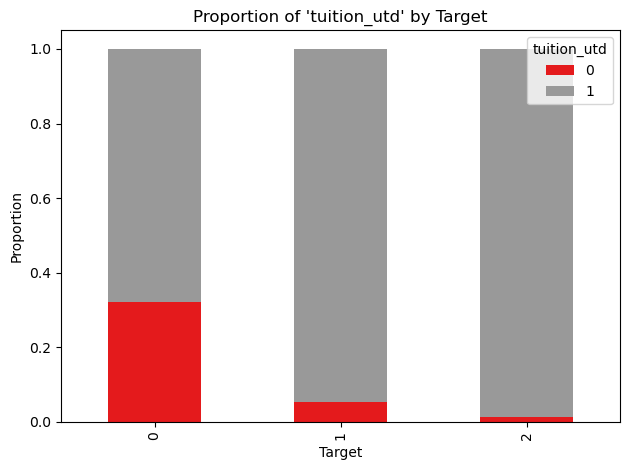

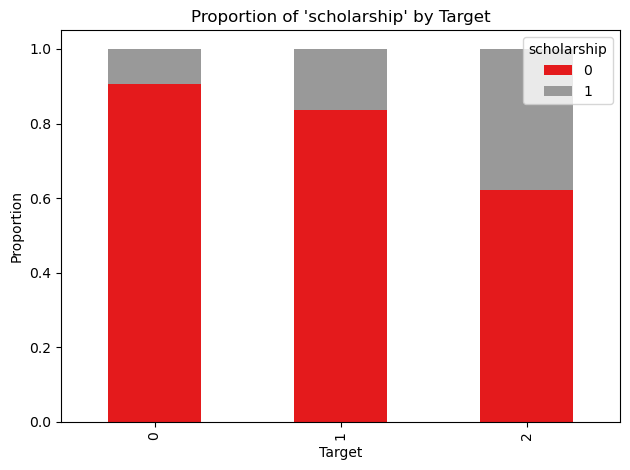

In [286]:
def plot_proportional_bar(feature_):
    prop_df = df_selected_features.groupby("Target")[feature_].value_counts(normalize=True).unstack()
    prop_df.plot(kind="bar", stacked=True, colormap="Set1")
    plt.title(f"Proportion of '{feature_}' by Target")
    plt.ylabel("Proportion")
    plt.xlabel("Target")
    plt.legend(title=feature_, loc='upper right')
    plt.tight_layout()
    plt.show()

plot_proportional_bar("tuition_utd")
plot_proportional_bar("scholarship")

As seen in the second graph, students with a scholarship rarely drop out. Combined with prior findings, this further implies that the student's own finances is one of the strongest correlations with graduation. 

# Train/Test Split

### Code to generate Train/Test Split (Do not rerun)
The data was split using stratified sampling with a fixed number seed.

In [290]:
'''df = pd.read_csv("reduced_data.csv")

X = df.drop("Target", axis = 1)
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20250323, stratify=y)

# Scale features for models that require scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# Save unscaled
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)

# Save scaled
pd.DataFrame(X_train_scaled, columns=X.columns).to_csv("X_train_scaled.csv", index=False)
pd.DataFrame(X_test_scaled, columns=X.columns).to_csv("X_test_scaled.csv", index=False)

# Targets
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

# Confirm shapes
print("Training set shape", X_train.shape)
print("Test set shape", X_test.shape)
print("Feature columns:", list(X.columns))'''

'df = pd.read_csv("reduced_data.csv")\n\nX = df.drop("Target", axis = 1)\ny = df["Target"]\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=20250323, stratify=y)\n\n# Scale features for models that require scaling\nscaler = StandardScaler()\n\nX_train_scaled = scaler.fit_transform(X_train)\n\nX_test_scaled = scaler.transform(X_test)\n\n# Save unscaled\nX_train.to_csv("X_train.csv", index=False)\nX_test.to_csv("X_test.csv", index=False)\n\n# Save scaled\npd.DataFrame(X_train_scaled, columns=X.columns).to_csv("X_train_scaled.csv", index=False)\npd.DataFrame(X_test_scaled, columns=X.columns).to_csv("X_test_scaled.csv", index=False)\n\n# Targets\ny_train.to_csv("y_train.csv", index=False)\ny_test.to_csv("y_test.csv", index=False)\n\n# Confirm shapes\nprint("Training set shape", X_train.shape)\nprint("Test set shape", X_test.shape)\nprint("Feature columns:", list(X.columns))'

# Decision Tree Model

In [2]:
# Load data
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

# Initialize Decision Tree Model
dt = DecisionTreeClassifier(random_state=20250323)

# Hyperparameter Grid
param_grid = {
    "max_depth": [3,5,7,10, None],
    "min_samples_split": [2,5,10,15],
    "min_samples_leaf": [1,2,4,6]
    }

# Grid Search
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,
    verbose=1
    )

grid_dt.fit(X_train, y_train)

# Final Model
best_dt = grid_dt.best_estimator_
print("Hyperparameters:" , grid_dt.best_params_)

y_pred_dt = best_dt.predict(X_test)

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
confmatrix = confusion_matrix(y_test, y_pred_dt)
print(confmatrix)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 15}

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       284
           1       0.46      0.16      0.24       159
           2       0.75      0.93      0.83       442

    accuracy                           0.73       885
   macro avg       0.65      0.61      0.61       885
weighted avg       0.70      0.73      0.70       885

Confusion Matrix:
[[213  17  54]
 [ 54  26  79]
 [ 19  14 409]]


## Confusion matrix heatmap 
After running this the first time, adding percentages seemed like a good idea to make it more readable/understandable.

Row normalization shows the recall (% of correctly indentified outcomes from total)

Column normalization shows precision (% of correctly identified outcomes from predictions )

In order to intervene with students at risk of dropping out, focusing on recall is more important.

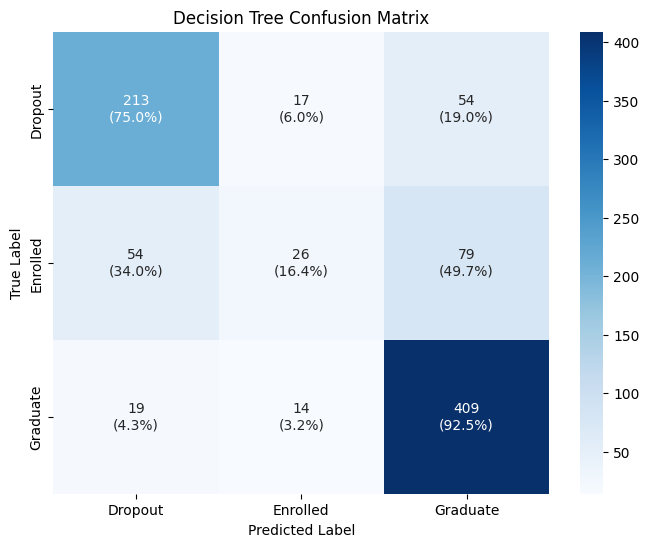

In [3]:
# make labels with % Recall
confmatrix_percent = confmatrix.astype('float') / confmatrix.sum(axis=1)[:, np.newaxis] * 100

newLabels = np.empty_like(confmatrix).astype(str)

for i in range(confmatrix.shape[0]):
    for j in range(confmatrix.shape[1]):
        count = confmatrix[i,j]
        percent = confmatrix_percent[i,j]
        newLabels[i,j] = f"{count}\n({percent:.1f}%)"

labels = ["Dropout", "Enrolled", "Graduate"]
plt.figure(figsize=(8,6))
sns.heatmap(confmatrix, annot=newLabels, fmt="", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Decision Tree Confusion Matrix")
plt.show()

This shows strong findings, moreso positive than negative. We can make accurate predictions that a student will succeed in graduation, but predicting if a student will dropout is made with less confidence. 

## Linear Regression with Subset Selection #1

In [5]:
# Load data
X_train_prepped = pd.read_csv("X_train_scaled.csv")
X_test_prepped = pd.read_csv("X_test_scaled.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

# Ensure y_train is 1D
y_train = y_train.values.ravel()  

# Linear Regression Model
lr_model = LinearRegression()

# Feature Selection using RFE
rfe = RFE(lr_model, n_features_to_select=6)
X_train_selected = rfe.fit_transform(X_train_prepped, y_train)

# Get selected feature names
selected_feature_indices = np.where(rfe.support_)[0]
selected_features = X_train_prepped.columns[selected_feature_indices].tolist()

# Subset the original datasets
X_train_selected = X_train_prepped[selected_features]
X_test_selected = X_test_prepped[selected_features]

# Fit the model
lr_model.fit(X_train_selected, y_train)

# Get coefficients
selected_coefficients = lr_model.coef_.tolist()

# Construct DataFrame 
coeffs_df = pd.DataFrame({'Selected Feature': selected_features, 'Coefficient': selected_coefficients})
coeffs_df = coeffs_df.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

# Model predictions
y_pred = lr_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model\n")
print("Root Mean Squared Error (RMSE):", round(rmse, 4))

train_r2 = lr_model.score(X_train_selected, y_train)
test_r2 = r2_score(y_test, y_pred)

print("Train R-squared (R2):", round(train_r2, 4))
print("Test R-squared (R2):", round(test_r2, 4))

Linear Regression Model

Root Mean Squared Error (RMSE): 0.6364
Train R-squared (R2): 0.4853
Test R-squared (R2): 0.4863


That's a very high RMSE, which is bad, and a low R2, which is also bad. This model is only right about half the time. Let's see if we can see why.

In [6]:
# Display DataFrame
display(coeffs_df)

,Selected Feature,Coefficient
0,2nd_sem_approved,0.506620
4,tuition_utd,0.186202
2,1st_sem_approved,-0.157605
5,scholarship,0.128623
1,2nd_sem_grade,0.126338
3,1st_sem_grade,0.025775


1st_sem_approved was positive in the original exploratory data analysis but is now coming back negative. This might skew the data even though the rest of the features are correctly positive. Let's see how this would make an impact in charts.

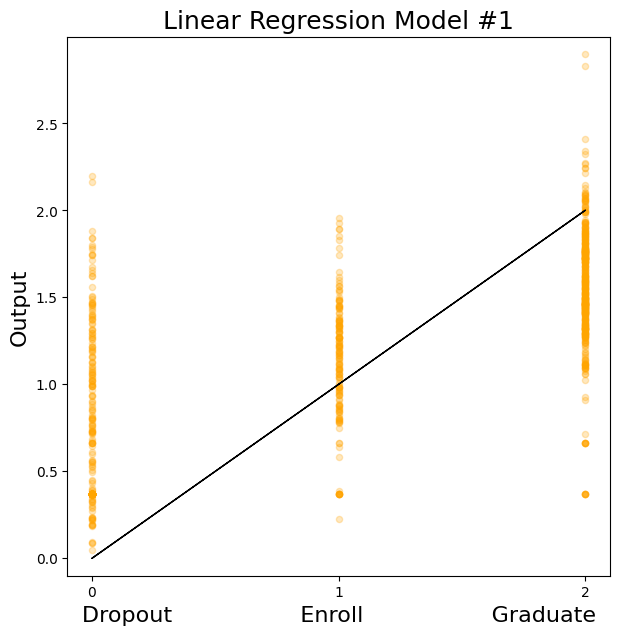

In [7]:
# Ensure y_test and y_pred are numeric
y_test = pd.to_numeric(y_test.squeeze(), errors='coerce')
y_pred = pd.to_numeric(y_pred.squeeze(), errors='coerce')

# Plot Linear Regressor #1 Results
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))

ax1.scatter(y_test, y_pred, alpha=0.25, s=20, color='orange')
ax1.plot(y_test, y_test, linewidth=1, color='black')

ax1.set_xlabel('Dropout                  Enroll                  Graduate', fontsize=16)
ax1.set_ylabel('Output', fontsize=16)

# Ensure max values are numeric before adding
ax1.set_xlim(-0.1, float(max(y_test)) + 0.1)
ax1.set_ylim(-0.1, float(max(y_pred)) + 0.1)

# Set x-axis ticks to whole numbers only
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_title("Linear Regression Model #1", fontsize=18)

plt.show()

This makes it seem like there isn't a huge difference between Dropout and Enroll, but Graduate is clearly higher, due to the trend line.

Let's try another type of chart to get another perspective. 

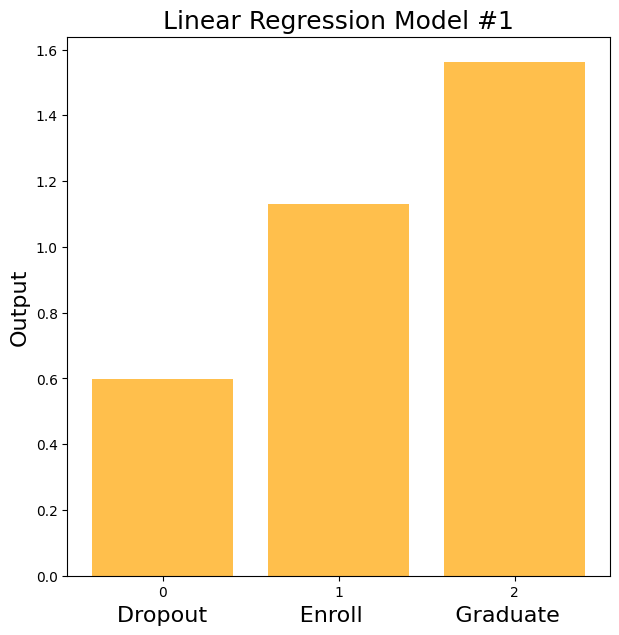

In [8]:
# Ensure y_test and y_pred are numeric
y_test = pd.to_numeric(y_test.squeeze(), errors='coerce')
y_pred = pd.to_numeric(y_pred.squeeze(), errors='coerce')

# Convert to DataFrame for grouping
df = pd.DataFrame({'True Output': y_test, 'Predicted Output': y_pred})

# Compute average prediction for each unique x-axis value (0, 1, 2)
bar_data = df.groupby('True Output')['Predicted Output'].mean()

# Plot as a bar chart
fig, ax = plt.subplots(figsize=(7, 7))

ax.bar(bar_data.index, bar_data.values, color='orange', alpha=0.7)

# Labels and title
ax.set_xlabel('Dropout             Enroll             Graduate', fontsize=16)
ax.set_ylabel('Output', fontsize=16)
ax.set_title("Linear Regression Model #1", fontsize=18)

# Set x-axis ticks to whole numbers only
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Show plot
plt.show()

This bar chart makes a more clear difference between each section.

In [9]:
# Convert NumPy arrays to DataFrames/Series if needed
if isinstance(X_train_selected, np.ndarray):
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
if isinstance(X_test_selected, np.ndarray):
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train)
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test)

# Perform cross-validation and get predictions on the model
X_selected = pd.concat([X_train_selected, X_test_selected], axis=0)
y_selected = pd.concat([y_train, y_test], axis=0)

y_cv_pred = cross_val_predict(lr_model, X_selected, y_selected, cv=5)

r2_cv = r2_score(y_selected, y_cv_pred)

print("Linear Regression Model #1 Performance\n")
print("Cross-Validation Predictions R-squared (R2):", round(r2_cv, 4))

Linear Regression Model #1 Performance

Cross-Validation Predictions R-squared (R2): 0.4838


This R2 is almost the exact same as on the test and train from earlier. Linear Regression might just not be a good fit with this data, but let's try one more way to make sure using polynomials. 

## Linear Regression with Subset Selection #2

In [10]:
poly = PolynomialFeatures( degree = 3 )

X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

print("X_train_poly shape", X_train_poly.shape, "\n")

print("Some of the New Polynomial Features:\n")

for i in range(15, 35):
    print("- ", poly.get_feature_names_out()[i])
print()

X_train_poly shape (3539, 84) 

Some of the New Polynomial Features:

-  2nd_sem_grade 1st_sem_grade
-  2nd_sem_grade tuition_utd
-  2nd_sem_grade scholarship
-  1st_sem_approved^2
-  1st_sem_approved 1st_sem_grade
-  1st_sem_approved tuition_utd
-  1st_sem_approved scholarship
-  1st_sem_grade^2
-  1st_sem_grade tuition_utd
-  1st_sem_grade scholarship
-  tuition_utd^2
-  tuition_utd scholarship
-  scholarship^2
-  2nd_sem_approved^3
-  2nd_sem_approved^2 2nd_sem_grade
-  2nd_sem_approved^2 1st_sem_approved
-  2nd_sem_approved^2 1st_sem_grade
-  2nd_sem_approved^2 tuition_utd
-  2nd_sem_approved^2 scholarship
-  2nd_sem_approved 2nd_sem_grade^2



In [11]:
# Expanded train data
lr_model.fit(X_train_poly, y_train)

y_pred = lr_model.predict(X_test_poly)

# Evaluated model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", round(rmse, 4))

train_r2 = lr_model.score(X_train_poly, y_train)
test_r2 = r2_score(y_test, y_pred)

# Comparing the train and test R-squared
print("Train R-squared (R2):", round(train_r2, 4))
print("Test R-squared (R2):", round(test_r2, 4))

Root Mean Squared Error (RMSE): 0.5927
Train R-squared (R2): 0.5701
Test R-squared (R2): 0.5545


That's a slightly lower RMSE than our prior finding of 0.6364, and a higher R2 than the prior 0.4853, so this chart seems slightly more useful. Let's check if this reflects in charts.

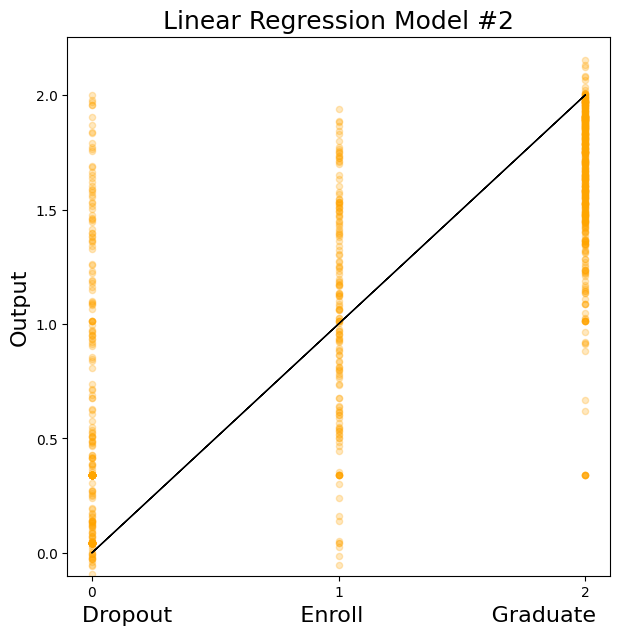

In [13]:
# Plot Linear Regressor #2 Results
fig, ax1 = plt.subplots(1,1, figsize=(7, 7))

ax1.scatter(y_test, y_pred, alpha=0.25, s=20, color='orange')
ax1.plot(y_test, y_test, linewidth=1, color='black')

ax1.set_xlabel('Dropout                  Enroll                  Graduate', fontsize=16)
ax1.set_ylabel('Output', fontsize=16)
ax1.set_xlim(-0.1, float(max(y_test)) + 0.1)
ax1.set_ylim(-0.1, float(max(y_pred)) + 0.1)
ax1.set_title("Linear Regression Model #2", fontsize=18)

# Set x-axis ticks to whole numbers only
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

The y-axis only goes to 2.0, while the last scatter plot went to 2.5, so this chart is more condensed. Dropout and Enroll have greater variance, while Graduate is clearly higher. 

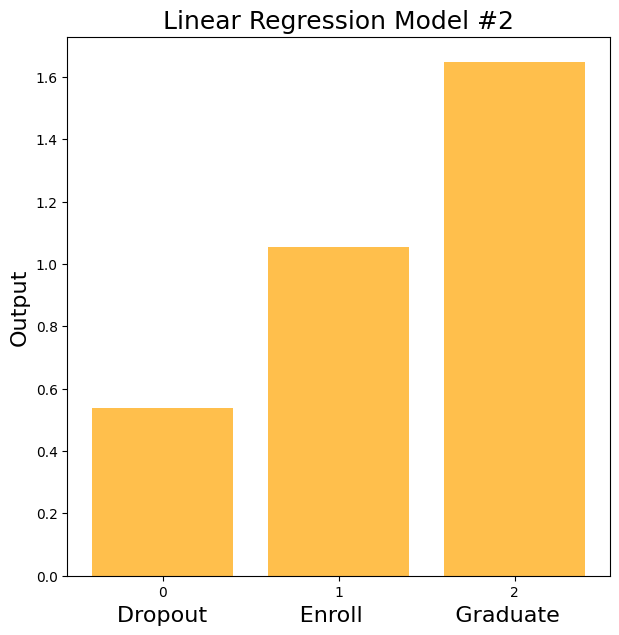

In [14]:
# Ensure y_test and y_pred are numeric
y_test = pd.to_numeric(y_test.squeeze(), errors='coerce')
y_pred = pd.to_numeric(y_pred.squeeze(), errors='coerce')

# Convert to DataFrame for grouping
df = pd.DataFrame({'True Output': y_test, 'Predicted Output': y_pred})

# Compute average prediction for each unique x-axis value (0, 1, 2)
bar_data = df.groupby('True Output')['Predicted Output'].mean()

# Plot as a bar chart
fig, ax = plt.subplots(figsize=(7, 7))

ax.bar(bar_data.index, bar_data.values, color='orange', alpha=0.7)

# Labels and title
ax.set_xlabel('Dropout             Enroll             Graduate', fontsize=16)
ax.set_ylabel('Output', fontsize=16)
ax.set_title("Linear Regression Model #2", fontsize=18)

# Set x-axis ticks to whole numbers only
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Show plot
plt.show()

Dropout and Enroll are slightly lower, so this model seems to predict graduation at the same rate, but is more accurate on the other outcomes. 

In [15]:
# Perform cross-validation and get predictions on the model

X_poly = pd.concat([pd.DataFrame(X_train_poly), pd.DataFrame(X_test_poly)], axis = 0)
y_poly = pd.concat([y_train, y_test], axis = 0)
y_cv_pred = cross_val_predict(lr_model, X_poly, y_poly, cv=5)

r2_cv = r2_score(y_poly, y_cv_pred)
print("Cross-Validation Predictions R-squared (R2)", round(r2_cv, 4))

Cross-Validation Predictions R-squared (R2) 0.539


This is slightly better than the Model 1's final R2 of 0.4838, as we want a higher R2. Since our Y-output is only 0, 1, and 2, using Linear Regression might not be effective. 

# Conclusion

The Decision Tree does an excellent job of prediction both graduation and failing a class. The number of classes a student takes each semester and tuition being up to date are the strongest positive factors, showing the importance of a student's fiannces. Using this model, we might make recommendations that more scholarships focus on cost of living needs outside of school fees, so students can dedicate their full time to classes.

The Linear Regression did poorly in predicting anything useful, as it was only correct about half of the time. For alterantives, Random Forest might end up just as useless. KNN might be a better for this data than Linear Regression, as we could easily plot that in another confusion matrix.  

If we were to repeat our project and make changes, we could likely take out the Enroll target, since we didn't find any meaningful data from that section. It seems that students generally enroll in classes until they either dropout of a class or graduate their program; rarely do students stop enroll in classes otherwise. 